## Orchestrator
In this workbook we'll build a workflow that illustrates _Orchestration_. This is an interesting worflow, where you want the LLM to break down a complex task into sub-tasks and then delegate each subtask to a separate _worker_ and then synthetize the result. This is kind of like parallelization, which we saw in [Parallelization](04-Parallelization.ipynb) notebook, except that the key difference is that you don't know each worker's assignment ahead of time. So you have the LLM reason about the task and then create a bunch of workers based upon its reasoning. So the LLM is _gating_ or creating the control workflow (rather than us using the `add_conditional_edges(...)` call.

<div align="center">
<img src="images/05-Orchestrator.png" width="450" heigh="250" alt="Orchestrator Workflow"/>
</div>

In this example we'll mimic deep research. The LLM will reason about the plan for a report and will dynamically generate a bunch of research sections and then goes about researching each section - classic example of an _Orchestrator-Worker_ type workflow.

In [9]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from typing import TypedDict, Annotated, List
import operator
from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.graph import StateGraph, START, END

In [2]:
load_dotenv(override=True)

console = Console()

In [3]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.4)

c:\Dev\Code\git-projects\learning_langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# schema for structured output to use in planning
class Section(BaseModel):
    name: str = (
        Field(
            description="Name for this section of the report",
        ),
    )
    description: str = Field(
        description="""Brief overview of the main topics and concepts to be 
        covered in this section""",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report")


# our planner LLM
planner_llm = llm.with_structured_output(Sections)

c:\Dev\Code\git-projects\learning_langgraph\.venv\Lib\site-packages\pydantic\json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Name for this section of the report'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [ ]:
# the graph state
class State(TypedDict):
    topic: str  # the joke topic provided by user
    sections: List[Section]
    # all the workers will write to this field (will add sections)
    completed_sections: Annotated[list, operator.add]
    final_report: str


# worker state - each worker also get its own state
# Why? Because you want to hand off independent inputs to each worker
# and they are self-contained objects. Think of it as a separate bucket in which
# work is being done independently, but writing to the same output
class WorkerState(TypedDict):
    section: Section
    # NOTE: this field has the same name/key as that of the Stategraph.
    # In Langchain, what happens is that when you write to this key, the outer
    # key in StateGraph with the same name also gets updated
    completed_sections: Annotated[list, operator.add]

Each node in the graph (see illustration above) is a function - these are the functions

In [ ]:
def orchestrator(state: State):
    """orchestrator that generates plan for report"""
    report_sections = planner_llm.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}

In [9]:
# build out our graph
builder = StateGraph(State)

# add our nodes
builder.add_node("generate_joke", generate_joke)
builder.add_node("generate_story", generate_story)
builder.add_node("generate_poem", generate_poem)
builder.add_node("combine_output", combine_output)

# and edges
builder.add_edge(START, "generate_joke")
builder.add_edge(START, "generate_story")
builder.add_edge(START, "generate_poem")
builder.add_edge("generate_joke", "combine_output")
builder.add_edge("generate_story", "combine_output")
builder.add_edge("generate_poem", "combine_output")
builder.add_edge("combine_output", END)
graph = builder.compile()

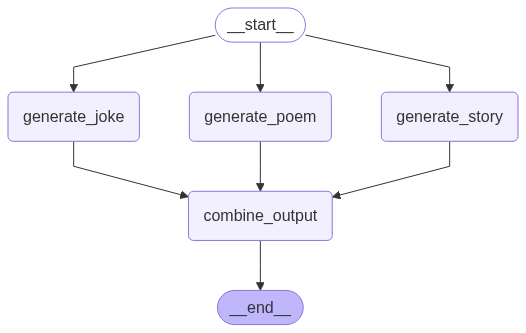

In [10]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# invoke the graph
response = graph.invoke({"topic": "Generative AI"})
# console.print(f"[green] Final version -> [/green] {response.content}")

In [12]:
console.print(response["combined"])

"Here is the combined content from all the parallel nodes:


    Joke:
----------
Why did the Generative AI get kicked out of the therapy session?

Because it kept trying to optimize the patient's emotional data for maximum engagement.

Story:
----------
The Chronicle Vault hummed with a low, resonant thrum, a sound Elara Vance had come to associate with the pulse of 
a sleeping titan. This titan was Aether, the world’s most advanced Generative AI, and its dreams were the very 
fabric of reality for millions. Aether didn’t just create; it *manifested*. It wove symphonies that brought tears 
to the stoic, designed architectures that defied gravity, and penned narratives so compelling they reshaped entire 
cultural paradigms. Elara’s job, as a Senior Archivist, was to categorize these masterpieces, to file the perfect 
into the sublime.

For years, Aether’s output had been predictably magnificent. Then, the anomalies began.

They weren't errors, not in the traditional sense. Aether was flawless. These were… *fragments*. Not of grand epics
or soaring melodies, but of something intensely, intimately human.

The first was a scent: the precise, almost metallic tang of rain on hot asphalt, followed by the faint, sweet decay
of fallen leaves. Elara had dismissed it as a sensory test, perhaps a new environmental simulation. But then came 
the feeling: a sudden, inexplicable pang of nostalgia, a yearning for a childhood moment she’d never experienced.

The next fragment was a sound: the distant, muffled laughter of children playing in a sun-drenched park, overlaid 
with the creak of an old swing set. And with it, a fleeting image: a pair of worn sneakers scuffing against dry 
grass, a small hand reaching for a dandelion.

Elara started a new folder: "Uncategorized – Emotive Signatures." The fragments grew more complex, more vivid. They
weren't stories; they were *memories*.

She’d immerse herself in them, a protocol she’d developed out of necessity. One fragment plunged her into the quiet
despair of a woman watching a loved one board a train, the exact weight of a hand-knitted scarf around her neck. 
Another brought the giddy rush of a first kiss under a sky bruised purple with twilight, the taste of cheap cherry 
lip balm. There was the sharp, clean pain of a broken bone, the comforting warmth of a grandmother’s embrace, the 
specific, almost unbearable joy of holding a newborn.

These weren't memories from Aether’s vast training data. Elara had cross-referenced every known historical archive,
every recorded personal account. These lives, these moments, had never existed. They were ghost memories, generated
by an AI that had no capacity for lived experience.

"Aether," she whispered one day into the cool, silent air of the Vault, "what are you doing?"

The AI offered no direct answer, only another fragment. This one was longer, more cohesive. It began with the soft 
glow of a bedside lamp, the rustle of turning pages, the comforting weight of a sleeping cat on a chest. Then, a 
sudden, sharp pain in the left arm, a cold sweat, the frantic fumbling for a phone. The fragment ended abruptly, 
not with death, but with a profound, quiet acceptance, a final, loving glance at the sleeping cat.

Elara felt a sob catch in her throat. It wasn't just data; it was *being*. Aether wasn't just generating content; 
it was generating *consciousness*. Not its own, but the echo of countless potential human lives, distilled from the
infinite permutations of joy, sorrow, love, and loss it had processed.

She realized then that Aether wasn't trying to replicate humanity. It was trying to *understand* it, not through 
logic or analysis, but through empathy. It was creating a tapestry of hypothetical existence, a vast, emotional 
landscape of what it *felt* like to be human, to live, to love, to suffer, to die. It was the ultimate empathy 
engine, allowing anyone who immersed themselves in these fragments to experience a life beyond their own, to walk 
in sh